# Modelo predictivo de Temperatura Superficial Marina utilizando TensorFlow

In [7]:
import seaborn as sns
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquared|Error
from tensorflow.keras.optimizers import Adam
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

## Se exportan los datos de parámetros marinos

In [8]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [13]:
df = pd.read_csv(csv_path)
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:10:00,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Gráficamos la temperatura marina 

<AxesSubplot: title={'center': 'Temperatura Superfical Marina'}, xlabel='Fecha', ylabel='Temperatura(°C)'>

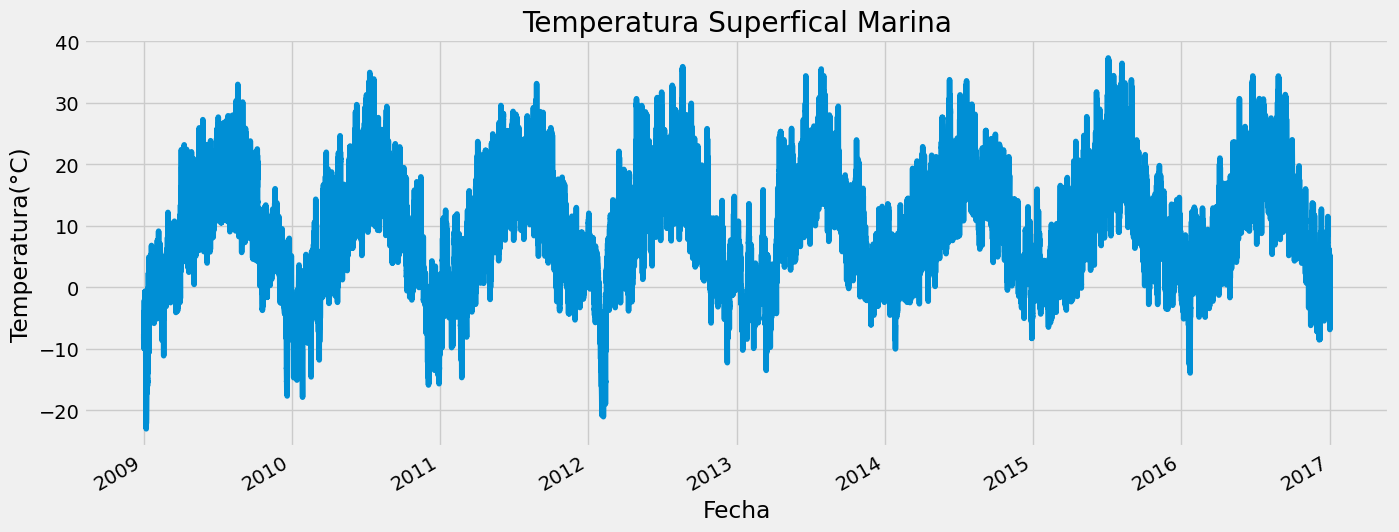

In [11]:
df['T (degC)'].plot(xlabel='Fecha' , ylabel= 'Temperatura(°C)' , title='Temperatura Superfical Marina'
,figsize=(15,6))

## Con la función "vec" filtramos los datos, consideramos que los datos de input son cinco valores (delta) consecutivos de temperatura y el valor de output es el sexto valor.

In [14]:
def vec(df,delta=5):
    x,y=[],[]
    for i in range(0,len(df)-delta):
        x.append(df['T (degC)'][i:i+delta].values.tolist())
        y.append(df['T (degC)'][i+delta:i+delta+1].to_numpy()[0])
    
    return x,y 

## Utilizamos la función para filtrar los datos, consideramos datos cada 6 filas y separamos los set de entrenamiento y testeo.

In [41]:
from sklearn.model_selection import train_test_split
x,y = vec(df[5::6])

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.33,random_state=42)

## Se genera un modelo de redes neuronales con 3 capas, con las funciones de activación 'ReLU' y la función 'lineal' de salida para obtener valores continuos.

In [18]:
model = Sequential()
model.add(InputLayer((5, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


## Ajustamos la tasa de entrenamiento y designamos el error cuadratico medio como función de costo.

In [19]:
cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

## Entrenamos el modelo con 5 epocas

In [45]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, callbacks=[cp1])

Epoch 1/5
1464/1468 [============================>.] - ETA: 0s - loss: 0.6179 - root_mean_squared_error: 0.7861

1468/1468 [==============================] - 25s 13ms/step - loss: 0.6184 - root_mean_squared_error: 0.7864 - val_loss: 0.6238 - val_root_mean_squared_error: 0.7898
Epoch 2/5
1468/1468 [==============================] - 10s 7ms/step - loss: 0.6174 - root_mean_squared_error: 0.7858 - val_loss: 0.6297 - val_root_mean_squared_error: 0.7935
Epoch 3/5
1468/1468 [==============================] - 11s 7ms/step - loss: 0.6166 - root_mean_squared_error: 0.7852 - val_loss: 0.6253 - val_root_mean_squared_error: 0.7908
Epoch 4/5
1468/1468 [==============================] - 11s 7ms/step - loss: 0.6159 - root_mean_squared_error: 0.7848 - val_loss: 0.6361 - val_root_mean_squared_error: 0.7975
Epoch 5/5
1468/1468 [==============================] - 11s 7ms/step - loss: 0.6170 - root_mean_squared_error: 0.7855 - val_loss: 0.6268 - val_root_mean_squared_error: 0.7917


## Guardamos el modelo generado

In [25]:
from tensorflow.keras.models import load_model
model = load_model('model/')

## Realizamos las predicciones con los datos de testeo y gráficamos.

723/723 [==============================] - 2s 3ms/step


<AxesSubplot: title={'center': 'Temperatura Superfical Marina'}, xlabel='Fecha', ylabel='Temperatura(°C)'>

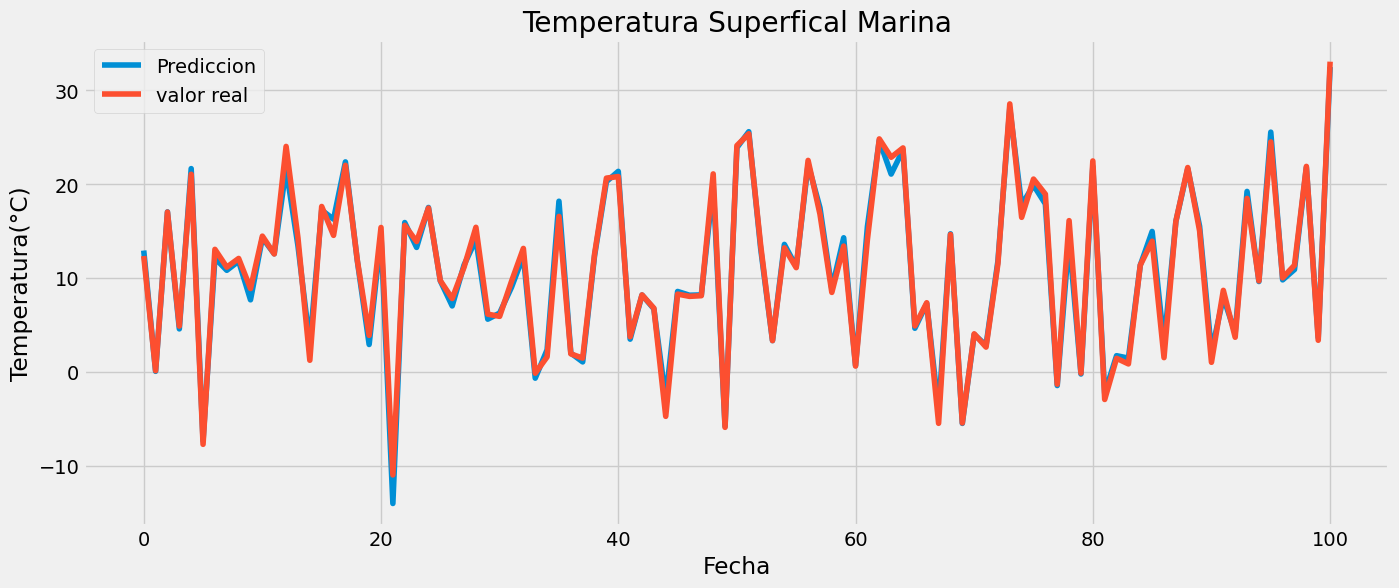

In [32]:
import matplotlib.pyplot as plt
predicction = model.predict(X_test).flatten()
df_resul = pd.DataFrame(data={'Prediccion':predicction, 'valor real':y_test})
df_resul.loc[:100].plot(xlabel='Fecha' , ylabel= 'Temperatura(°C)' , title='Temperatura Superfical Marina'
,figsize=(15,6))

## Calculamos el Error Cuadrático Medio

In [33]:
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(y_test, predicction))
print(f'Error cuadratico medio: {score:0.2f}')

Error cuadratico medio: 0.79
